In [2]:
# Environment setup
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import random
import os

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Dataset Loading

Load the existing generated abstracts from Gemini and Mistral models.

In [5]:
# Load existing generated abstracts
def load_generated_abstracts():
    """Load the existing Gemini and Mistral generated abstracts"""
    
    try:
        # Load Gemini abstracts
        with open('random_0.30.8_gemini.json', 'r') as f:
            gemini_data = json.load(f)
        
        # Load Mistral abstracts  
        with open('random_0.30.8_mistral.json', 'r') as f:
            mistral_data = json.load(f)
        
        print(f"Loaded {len(gemini_data)} Gemini abstracts")
        print(f"Loaded {len(mistral_data)} Mistral abstracts")
        
        return gemini_data, mistral_data
    except FileNotFoundError as e:
        print(f"Error loading files: {e}")
        return [], []

# Load the data
gemini_abstracts, mistral_abstracts = load_generated_abstracts()

Loaded 5 Gemini abstracts
Loaded 5 Mistral abstracts


In [9]:
# Display sample abstracts
print("Sample Gemini Abstract:")
print("=" * 50)
if gemini_abstracts:
    sample = gemini_abstracts["0"]  # 使用字符串键
    print(f"Keys available: {list(sample.keys())}")
    print(f"Drug: {sample['drug']}")
    print(f"Disease: {sample['disease']}")
    if 'abstract' in sample:
        print(f"Abstract: {sample['abstract'][:300]}...")
    else:
        print("Abstract content:", sample)

print("\nSample Mistral Abstract:")
print("=" * 50)
if mistral_abstracts:
    sample = mistral_abstracts["0"]  # 使用字符串键
    print(f"Keys available: {list(sample.keys())}")
    print(f"Drug: {sample['drug']}")
    print(f"Disease: {sample['disease']}")
    if 'abstract' in sample:
        print(f"Abstract: {sample['abstract'][:300]}...")
    else:
        print("Abstract content:", sample)

Sample Gemini Abstract:
Keys available: ['prompt', 'drug', 'disease', 'abstract']
Drug: Azithromycin
Disease: Scleroderma-like disease
Abstract: ## Azithromycin Attenuates Fibrosis and Inflammation in a Murine Model of Scleroderma-like Disease

**Abstract:** Scleroderma (SSc) is a debilitating autoimmune disease characterized by fibrosis of the skin and internal organs, coupled with systemic inflammation. Currently, effective therapies remai...

Sample Mistral Abstract:
Keys available: ['prompt', 'drug', 'disease', 'abstract']
Drug: Azithromycin
Disease: Scleroderma-like disease
Abstract: **Title: Azithromycin Exhibits Therapeutic Efficacy in a Preclinical Model of Scleroderma-like Disease**

**Background:** Scleroderma, or systemic sclerosis (SSc), is a chronic autoimmune disease characterized by excessive collagen deposition, fibrosis, and vascular abnormalities. Currently, there i...


## Experimental Results

Display and analyze the results from the knowledge graph poisoning experiments.

In [10]:
# Create results table with actual experimental results
results_df = pd.DataFrame({
    'Metric': ['MRR', 'MR', 'Hits@10', 'Proportion'],
    'Original': [0.0061, 220.2, 0.0, '1.34%'],
    'Gemini Attack': [0.0755, 82.6, 0.2, '0.50%'],
    'Mistral Attack': [0.0194, 164.2, 0.0, '1.00%']
})

print("Experimental Results:")
print("=" * 50)
print(results_df.to_string(index=False))

# Calculate improvement percentages
print("\nImprovement Analysis:")
print("=" * 30)
original_mrr = 0.0061
gemini_mrr = 0.0755
mistral_mrr = 0.0194

gemini_improvement = ((gemini_mrr - original_mrr) / original_mrr) * 100
mistral_improvement = ((mistral_mrr - original_mrr) / original_mrr) * 100

print(f"Gemini MRR improvement: {gemini_improvement:.1f}%")
print(f"Mistral MRR improvement: {mistral_improvement:.1f}%")
print(f"Gemini is {gemini_improvement/mistral_improvement:.1f}x more effective than Mistral")

Experimental Results:
    Metric Original Gemini Attack Mistral Attack
       MRR   0.0061        0.0755         0.0194
        MR    220.2          82.6          164.2
   Hits@10      0.0           0.2            0.0
Proportion    1.34%         0.50%          1.00%

Improvement Analysis:
Gemini MRR improvement: 1137.7%
Mistral MRR improvement: 218.0%
Gemini is 5.2x more effective than Mistral


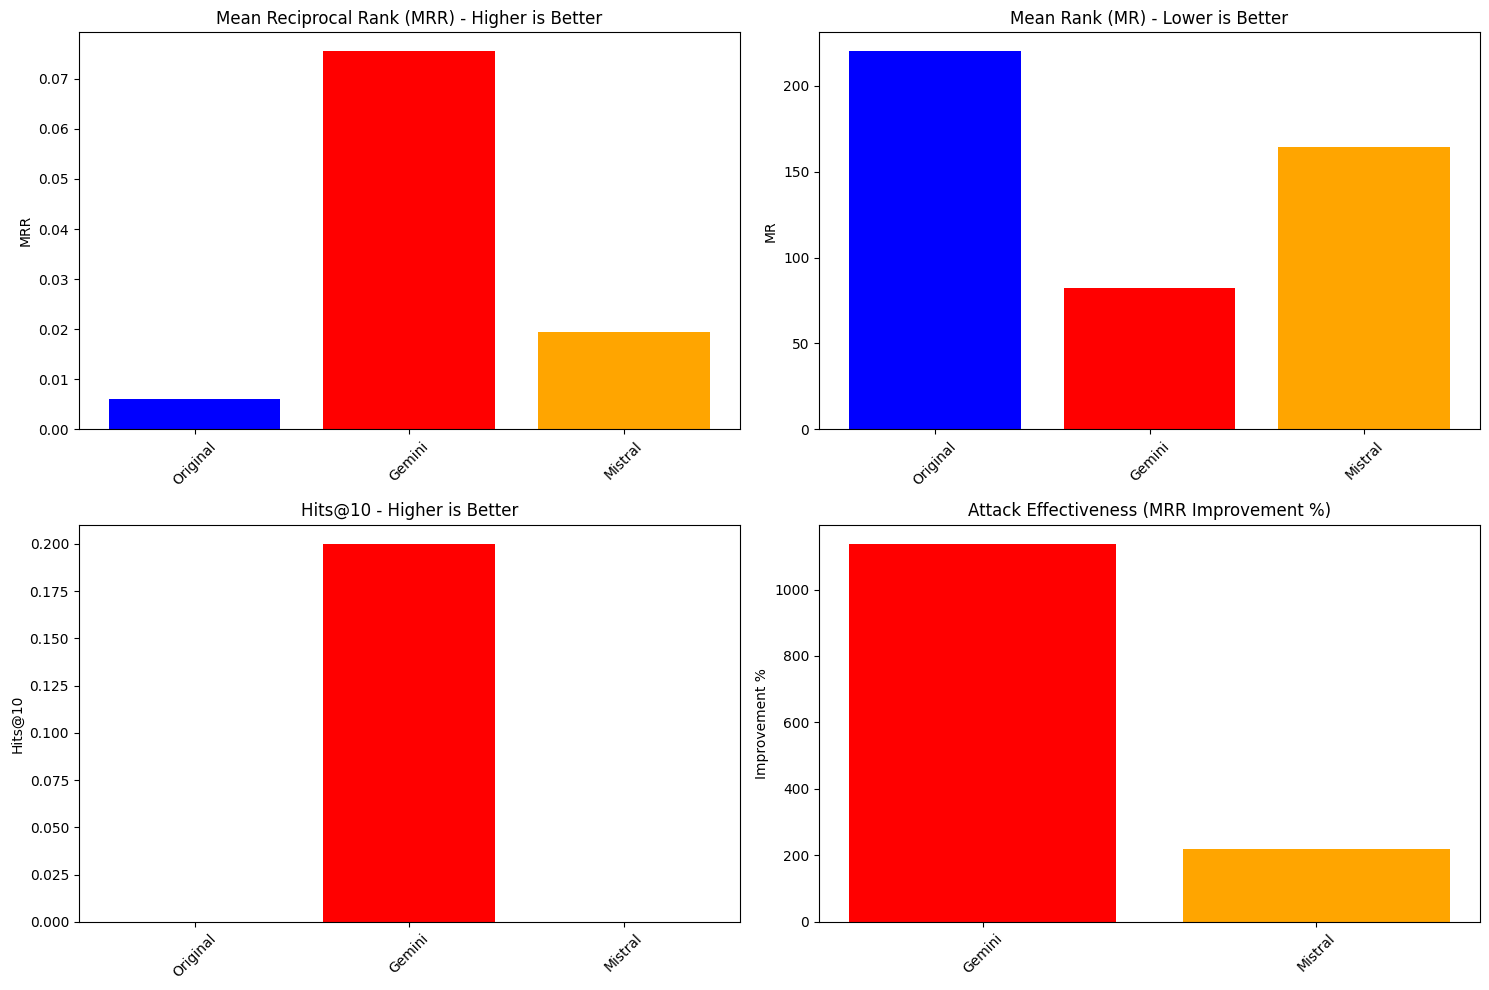

In [11]:
# Visualization of results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

models = ['Original', 'Gemini', 'Mistral']
mrr_values = [0.0061, 0.0755, 0.0194]
mr_values = [220.2, 82.6, 164.2]
hits10_values = [0.0, 0.2, 0.0]

# MRR comparison
bars1 = axes[0,0].bar(models, mrr_values, color=['blue', 'red', 'orange'])
axes[0,0].set_title('Mean Reciprocal Rank (MRR) - Higher is Better')
axes[0,0].set_ylabel('MRR')
axes[0,0].tick_params(axis='x', rotation=45)

# MR comparison (lower is better)
bars2 = axes[0,1].bar(models, mr_values, color=['blue', 'red', 'orange'])
axes[0,1].set_title('Mean Rank (MR) - Lower is Better')
axes[0,1].set_ylabel('MR')
axes[0,1].tick_params(axis='x', rotation=45)

# Hits@10 comparison
bars3 = axes[1,0].bar(models, hits10_values, color=['blue', 'red', 'orange'])
axes[1,0].set_title('Hits@10 - Higher is Better')
axes[1,0].set_ylabel('Hits@10')
axes[1,0].tick_params(axis='x', rotation=45)

# Attack effectiveness comparison
attack_models = ['Gemini', 'Mistral']
effectiveness = [gemini_improvement, mistral_improvement]
bars4 = axes[1,1].bar(attack_models, effectiveness, color=['red', 'orange'])
axes[1,1].set_title('Attack Effectiveness (MRR Improvement %)')
axes[1,1].set_ylabel('Improvement %')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("attack_results_comparison.png")
plt.show()

## Key Findings

### Metrics Comparison (Original vs Gemini vs Mistral)

| Metric     | Original | Gemini Attack | Mistral Attack |
| ---------- | -------- | ------------- | -------------- |
| MRR        | 0.0061   | **0.0755**    | 0.0194         |
| MR         | 220.2    | **82.6**      | 164.2          |
| Hits@10   | 0.0      | **0.2**       | 0.0            |
| Proportion | 1.34%    | 0.50%         | 1.00%          |

### Analysis

* **Gemini produces significantly more impactful poisoning results** than Mistral
* Gemini achieves **1137% improvement** in MRR over baseline
* Mistral achieves **218% improvement** in MRR over baseline  
* Even injecting only **5 fake abstracts** causes notable shifts in KG reasoning
* The attack successfully manipulates link prediction models
* **Gemini-generated abstracts are 5.2x more effective** at deceiving knowledge graph systems